Celis-Murillo, A., Malorodova, M., and Nakash, E., 2022, North American Bird Banding Program Dataset 1960-2022 retrieved 2022-07-14: U.S. Geological Survey data release, https://doi.org/10.5066/P9BSM38F.

Bird species selected from https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0004347#sec015 the feeding index

In [248]:
import csv
import geopandas as gpd
from collections import defaultdict
from collections import Counter
import pandas as pd
import tqdm as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import os

import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
rstats = importr('stats')

import scipy.stats as stats
from patsy import dmatrices
import statsmodels.api as sm

import seaborn as sns

In [3]:
state_colours = {"NY_light":"#618669", "NY_dark":"#4E5E48", "New_York_light": "#618669", "New_York_dark": "#4E5E48",
                 "MA_light":"#F1C081", "MA_dark":"#C08A46", "Massachusetts_light":"#F1C081", "Massachusetts_dark":"#C08A46",
                "CT_light":"#A83B17", "CT_dark":"#862E19", "Connecticut_light":"#A83B17", "Connecticut_dark":"#862E19",
                "other":"#62270C", "Other":"#62270C"}

In [142]:
years = []
for i in range(2003,2020):
    years.append((i))
    
months = []
for i in range(1,13):
    months.append(i)
states_codes = ["US-NY", "US-MA", "US-CT"]
#age range wanted is 1-8 - 0 is unknown

states = ["NY", "CT", "MA"]

In [14]:
high_birds = ["wood_thrush", "warbling_vireo", "chipping_sparrow","northern_cardinal", "american_robin", "common_grackle",
             "tufted_titmouse", "black-capped_chickadee"]
low_birds = ["american_goldfinch", "mourning_dove", "gray_catbird", "brown-headed_cowbird", "house_sparrow", 
            "black-and-white_warbler", "ovenbird", "house_wren"]

all_birds = set(high_birds + low_birds)
lookups = {}
for i in all_birds:
    string = i.replace("_"," ").title()
    if "-" not in i:
        lookups[string] = i
    elif i == "black-and-white_warbler":
        lookups["Black-and-white Warbler"] = i
    else:
        ind = string.rfind("-") + 1
        string = string[:ind] + string[ind].lower() + string[ind+1:]
        lookups[string] = i


In [19]:
bird_codes = {}
group = {}

bird_species_csv = ""

with open(bird_species_csv) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['SPECIES_NAME'] in lookups.keys():
            bird_codes[lookups[l['SPECIES_NAME']]] = l['SPECIES_ID']
            group[lookups[l['SPECIES_NAME']]] = l['BBL_GRP']
            

{'mourning_dove': '_12',
 'warbling_vireo': '_25',
 'black-capped_chickadee': '_26',
 'tufted_titmouse': '_26',
 'house_wren': '_30',
 'gray_catbird': '_31',
 'wood_thrush': '_35',
 'american_robin': '_35',
 'house_sparrow': '_35',
 'american_goldfinch': '_39',
 'chipping_sparrow': '_41',
 'brown-headed_cowbird': '_49',
 'common_grackle': '_47',
 'ovenbird': '_50',
 'black-and-white_warbler': '_50',
 'northern_cardinal': '_57'}

In [21]:
year_total_birds = defaultdict(dict)
year_total_birds["US-CT"] = defaultdict(dict)
year_total_birds["US-NY"] = defaultdict(dict)
year_total_birds["US-MA"] = defaultdict(dict)

directory_containing_bird_data = ""

for root, dirs, files in os.walk(directory_containing_bird_data):
    for file in tqdm.tqdm(files):
        if file.endswith(".csv") and file.startswith("NABBP"):
            with open(os.path.join(root,file)) as f:
                data = csv.DictReader(f)
                for l in data:
                    year = int(l['EVENT_YEAR'])
                    month = int(l['EVENT_MONTH'])
                    state = l['ISO_SUBDIVISION']
                    if year in years and state in states_codes:
                        if month in year_total_birds[state][year]:
                            year_total_birds[state][year][month] += 1
                        else:
                            year_total_birds[state][year][month] = 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 68061.73it/s]


In [34]:
def get_all_lines(bird):
    
    all_lines = []
    
    file_name = ""
    ID = bird_codes[bird]
    
    with open(file_name) as f:
        data = csv.DictReader(f)
        for l in data:
            year = int(l['EVENT_YEAR'])
            if l['SPECIES_ID'] == ID and l['BIRD_STATUS'] == "3" and l['ISO_SUBDIVISION'] in states_codes and year in years:
                all_lines.append(l)
                                
    return all_lines

In [35]:
bird_to_all_lines = defaultdict(list)
for bird in all_birds:
    print(bird)
    bird_to_all_lines[bird] = get_all_lines(bird)

house_sparrow
black-and-white_warbler
gray_catbird
house_wren
wood_thrush
chipping_sparrow
common_grackle
american_goldfinch
american_robin
tufted_titmouse
mourning_dove
brown-headed_cowbird
warbling_vireo
ovenbird
northern_cardinal
black-capped_chickadee


In [36]:
for k,v in bird_to_all_lines.items():
    print(k, len(v))


house_sparrow 2885
black-and-white_warbler 4878
gray_catbird 77419
house_wren 7743
wood_thrush 4180
chipping_sparrow 3971
common_grackle 3011
american_goldfinch 38657
american_robin 13037
tufted_titmouse 9679
mourning_dove 5589
brown-headed_cowbird 1418
warbling_vireo 1085
ovenbird 7088
northern_cardinal 9544
black-capped_chickadee 37933


In [103]:
def state_level_abundance(lst):

    ct = {}
    ma = {}
    ny = {}
    
    for line in lst:
        year = int(line["EVENT_YEAR"])
        if line["ISO_SUBDIVISION"] == "US-CT":
            if year in ct:
                ct[year] += 1
            else:
                ct[year] = 1
                
        elif line["ISO_SUBDIVISION"] == "US-MA":
            if year in ma:
                ma[year] += 1
            else:
                ma[year] = 1
        
        elif line["ISO_SUBDIVISION"] == "US-NY":
            if year in ny:
                ny[year] += 1
            else:
                ny[year] = 1
                
    for year in years:
        if year not in ct:
            ct[year] = 0
        if year not in ma:
            ma[year] = 0
        if year not in ny:
            ny[year] = 0
            
    ct = {k:v for k,v in sorted(ct.items(), key=lambda x:x[0])}
    ma = {k:v for k,v in sorted(ma.items(), key=lambda x:x[0])}
    ny = {k:v for k,v in sorted(ny.items(), key=lambda x:x[0])}

          
    return ct, ma, ny
            
def state_level_proportions(lst, total_birds):
    
    ct = defaultdict(dict)
    ma = defaultdict(dict)
    ny = defaultdict(dict)
    
    for line in lst:
        year = int(line["EVENT_YEAR"])
        month = int(line["EVENT_MONTH"])
        if line["ISO_SUBDIVISION"] == "US-CT":
            if month in ct[year]:
                ct[year][month] += 1
            else:
                ct[year][month] = 1
                
        elif line["ISO_SUBDIVISION"] == "US-MA":
            if month in ma[year]:
                ma[year][month] += 1
            else:
                ma[year][month] = 1
        
        elif line["ISO_SUBDIVISION"] == "US-NY":
            if month in ny[year]:
                ny[year][month] += 1
            else:
                ny[year][month] = 1
                
    ct_prop = defaultdict(dict)
    ma_prop = defaultdict(dict)
    ny_prop = defaultdict(dict)
    
    for year, month_dict in ct.items():
        for month, number in month_dict.items():
            total = total_birds["US-CT"][year][month]
            ct_prop[year][month] = round((number/total)*100, 2)
            
    for year, month_dict in ma.items():
        for month, number in month_dict.items():
            total = total_birds["US-MA"][year][month]
            ma_prop[year][month] = round((number/total)*100, 2)
            
    for year, month_dict in ny.items():
        for month, number in month_dict.items():
            total = total_birds["US-NY"][year][month]
            ny_prop[year][month] = round((number/total)*100, 2)
            
    for dict_prop in [ct_prop, ma_prop, ny_prop]:
        for year in years:
            if year not in dict_prop:
                for month in months:
                    dict_prop[year][month] = 0
            else:
                for month in months:
                    if month not in dict_prop[year]:
                        dict_prop[year][month] = 0
            
            dict_prop[year] = {k:v for k,v in sorted(dict_prop[year].items(), key=lambda x:x[0])}
    
        dict_prop = {k:v for k,v in sorted(dict_prop.items(), key=lambda x:x[0])}
    
          
    return ct_prop, ma_prop, ny_prop
            


In [141]:
def get_state_level_reg(state, overall_df, x_header, y_header, expr):
    
    df = overall_df.loc[overall_df['state'] == state]
    df = df.sort_values(by=x_header)
        
    y,x = dmatrices(expr, df, return_type='dataframe')
    poisson_results = sm.GLM(y,x, family=sm.families.Poisson()).fit()
    
    predictions = poisson_results.get_prediction(x)
    sum_frame = predictions.summary_frame()
    predicted_counts = sum_frame['mean']
    lower = sum_frame['mean_ci_lower']
    upper = sum_frame['mean_ci_upper']
    
    return df[x_header], df[y_header], predicted_counts, lower, upper, poisson_results.pvalues

In [38]:
case_dict = defaultdict(dict)

human_case_data_csv = ""
animal_case_data_csv = ""

with open(human_case_data_csv) as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        if l['state'] in states:
            year = int(l['year'])
            if year >= 2003 and year < 2020:
                if year in case_dict[l['state']]:
                    case_dict[l['state']][year] += int(l['count'])
                else:
                    case_dict[l['state']][year] = int(l['count'])
        
with open(animal_case_data_csv = "") as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        if l['species'] == "Equine":
            if l['state'] in states:
                year = int(l['year'])
                if year >= 2003 and year < 2020:
                    if year in case_dict[l['state']]:
                        case_dict[l['state']][year] += 1
                    else:
                        case_dict[l['state']][year] = 1
for state in states:                       
    for year in years:
        if year not in case_dict[state]:
            case_dict[state][year] = 0

['state', 'year', 'month', 'count']
['year', 'state', 'county', 'week', 'onsetdate', 'species', 'count']


In [148]:
ir_dict = defaultdict(dict)

ct_prevalence = ""
ma_prevalence = ""
ny_prevalence = ""

with open(ct_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        ir_dict["CT"][int(l['year'])] = float(l['prevalence'])
        
with open(ma_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['prevalence'] != "":
            ir_dict["MA"][int(l['year'])] = float(l['prevalence'])
        
with open(ny_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        ir_dict["NY"][int(l['year'])] = float(l['prevalence'])

In [137]:
abundances = defaultdict(dict)
for bird, lines in bird_to_all_lines.items():
    ct, ma, ny = state_level_abundance(lines)
    abundances[bird] = {"CT":ct, "MA":ma, "NY":ny}

In [154]:
proportions = defaultdict(dict)
for bird, lines in bird_to_all_lines.items():
    ct, ma, ny = state_level_proportions(lines, year_total_birds)
    proportions[bird] = {"CT":ct, "MA":ma, "NY":ny}

In [185]:

def get_bird_results(x_trait, y_trait,x_dict, y_dict):

    expr = f"""{y_trait} ~ {x_trait}"""
    bird_results = defaultdict(dict)

    for bird, state_dict in x_dict.items():
        for state, year_dict in state_dict.items():
            df_dict = defaultdict(list)
            for year, value in year_dict.items():
                df_dict['years'].append(year)
                df_dict[y_trait].append(y_dict[state][year])
                if type(value) == int:
                    df_dict[x_trait].append(value)
                else:
                    df_dict[x_trait].append(np.mean(list(value.values())))
                df_dict["state"].append(state)
                df_dict["colours"].append(state_colours[f'{state}_dark'])


            df = pd.DataFrame(df_dict)
            new_dict = {}
            new_dict["x"], new_dict['actual'], new_dict['predicted'], new_dict['lower'], new_dict['upper'], new_dict['p-value'] = get_state_level_reg(state, df, x_trait, y_trait, expr)
            bird_results[state][bird] = new_dict
            
    return bird_results


In [197]:

def make_figure(x_trait, y_trait, x_dict, y_dict, bird_list, save_name):

    fig, ax = plt.subplots(3,8, figsize=(30,10), sharex=False)
    fig.tight_layout()

    bird_results = get_bird_results(x_trait,y_trait,x_dict, y_dict)

    for state_no,state in enumerate(['CT', "MA", "NY"]):
        count = -1
        for bird, results in bird_results[state].items():
            if bird in bird_list:
                count += 1
                x = results['x']
                y = results['predicted']
                scatter_y = results['actual']

                lower = results['lower']
                upper = results['upper']

                colour = state_colours[f"{state}_dark"]

                ax[state_no,count].plot(x,y, color=state_colours[f"{state}_dark"])
                ax[state_no,count].fill_between(x,lower, upper, alpha=0.3, color=colour)
                ax[state_no,count].scatter(x,scatter_y, color=colour, s=50)

                x_2019 = x[16] 
                y_2019 = case_dict[state][2019]

                ax[state_no,count].scatter(x_2019, y_2019, marker="*", s=500, color=colour)
                value = results['p-value'][x_trait]
                ax[state_no,count].set_title(f'{state}:{bird} p={round(value,5)}') 

    plt.savefig(f"../../figures/supplementary/bird_fig/{save_name}.pdf", bbox_inches="tight")
    
    return bird_results

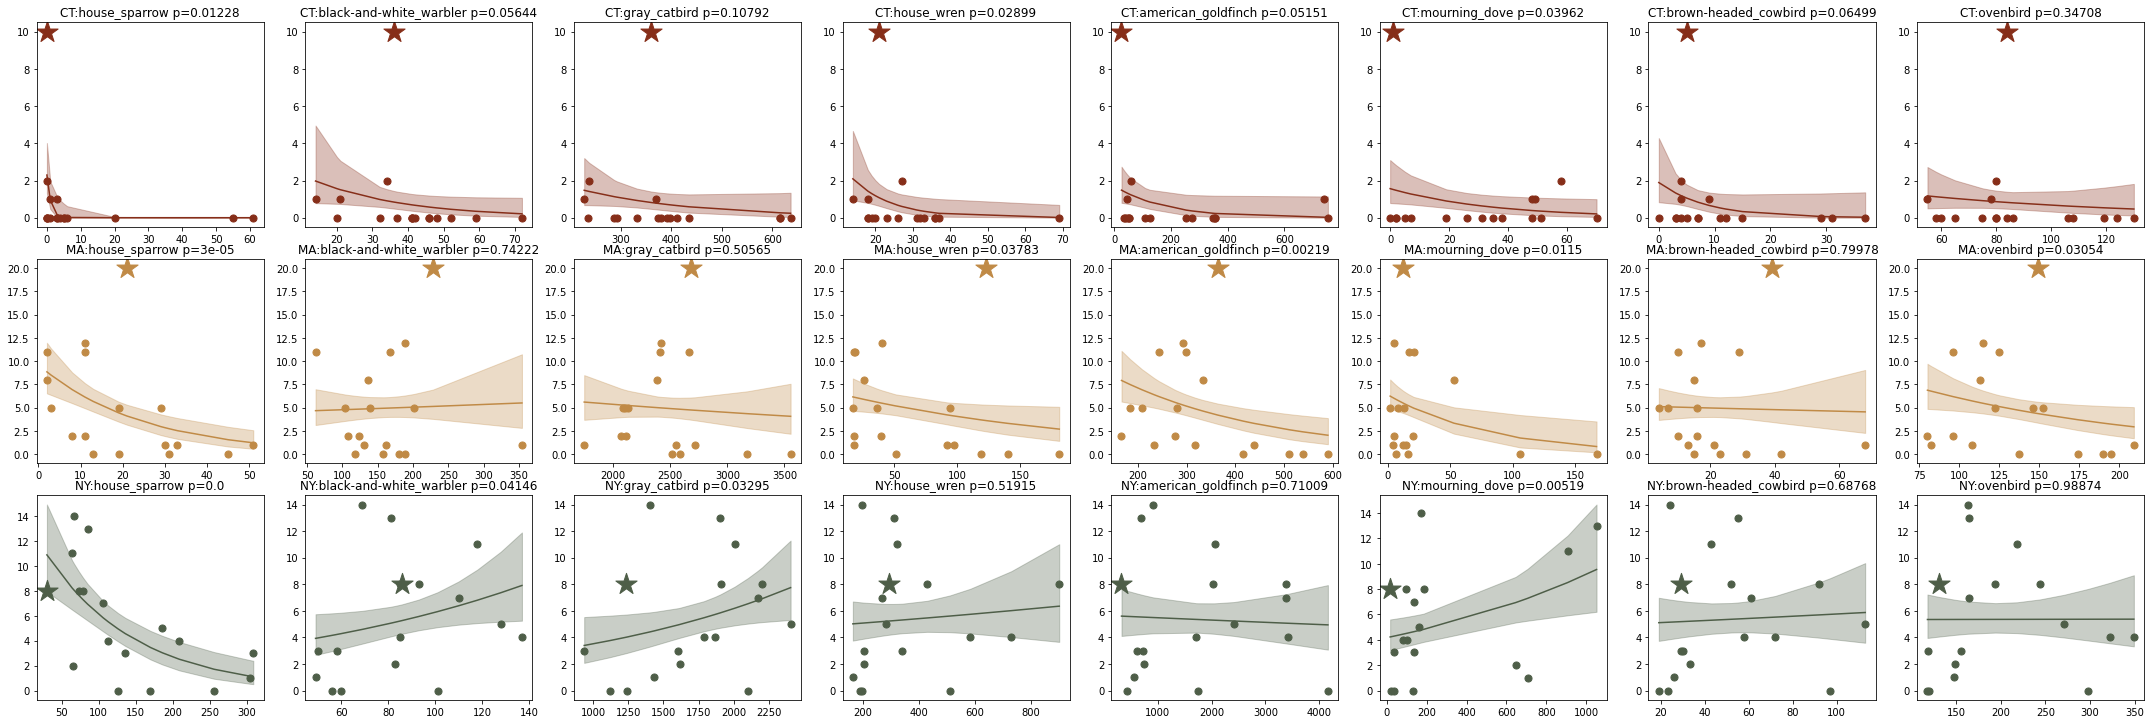

In [198]:
abun_case_low = make_figure("abundance", "cases", abundances, case_dict, low_birds, "abundance_cases_low.pdf")

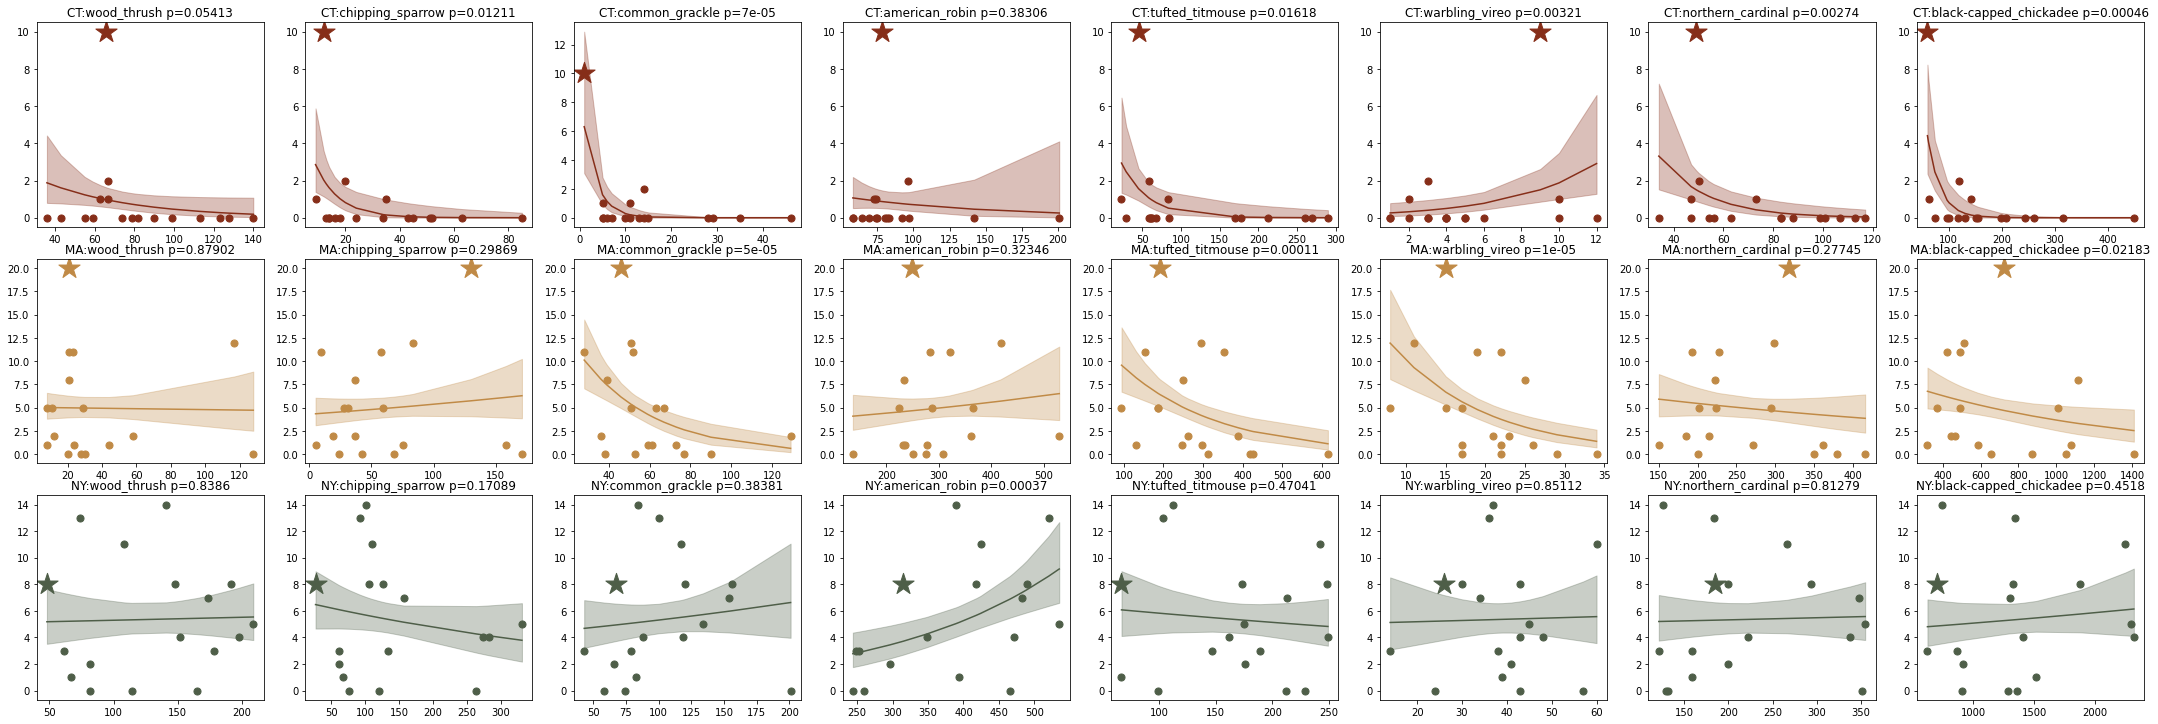

In [199]:
abun_case_high = make_figure("abundance", "cases", abundances, case_dict, high_birds, "abundance_cases_high.pdf")

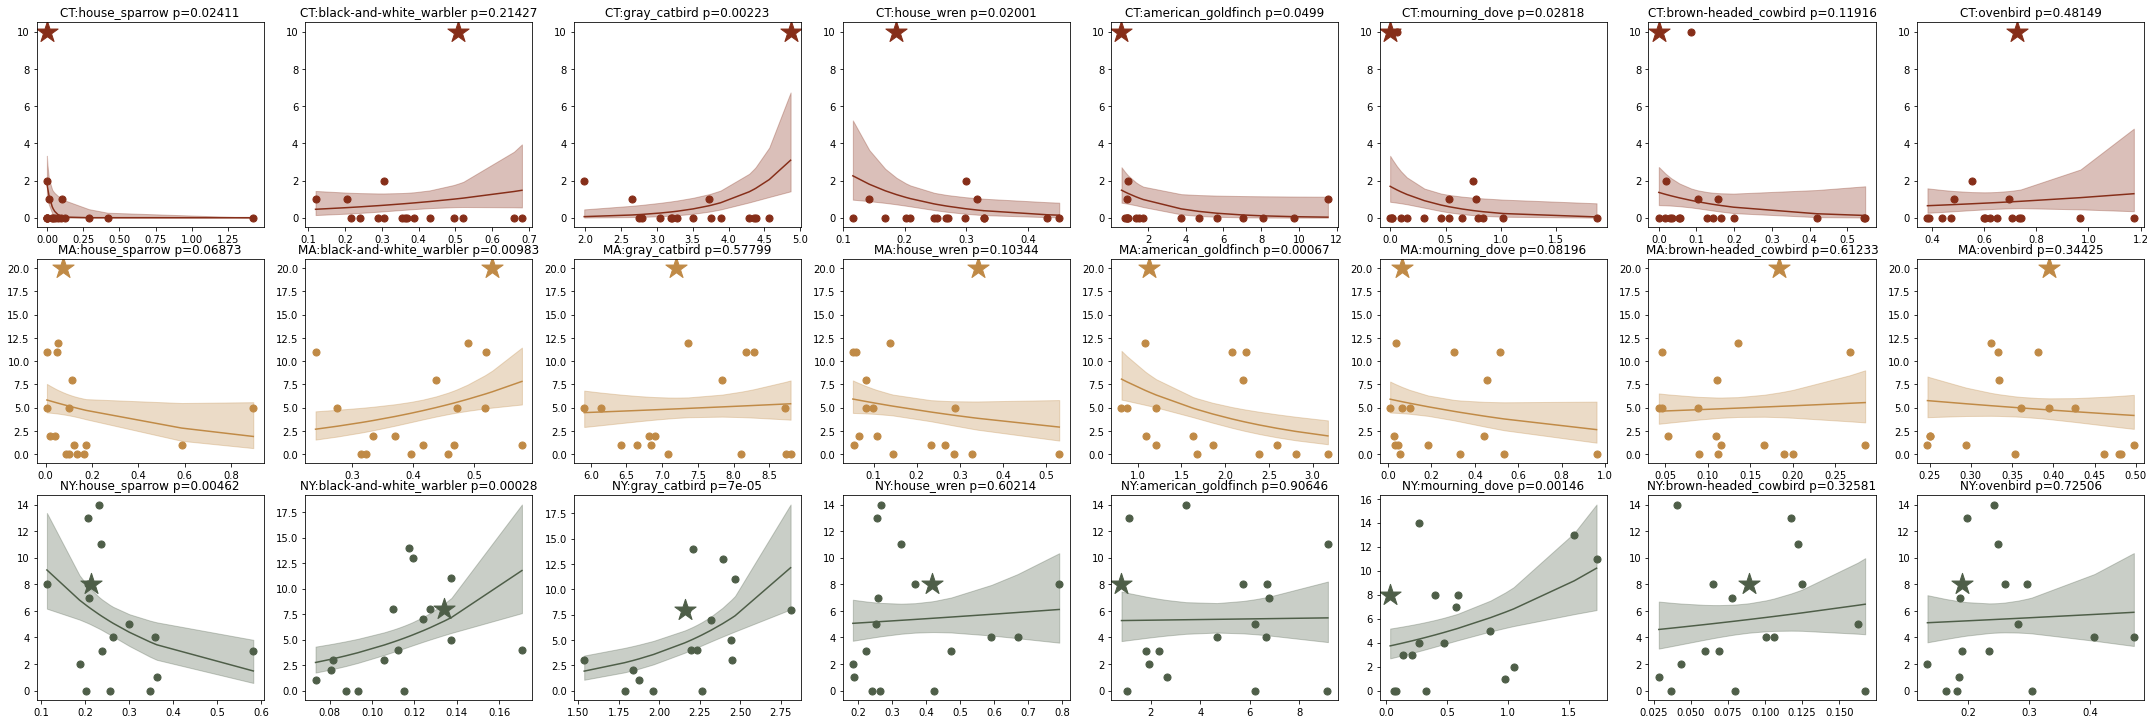

In [203]:
prop_case_low = make_figure("proportion", "cases", proportions, case_dict, low_birds, "proportion_cases_low.pdf")

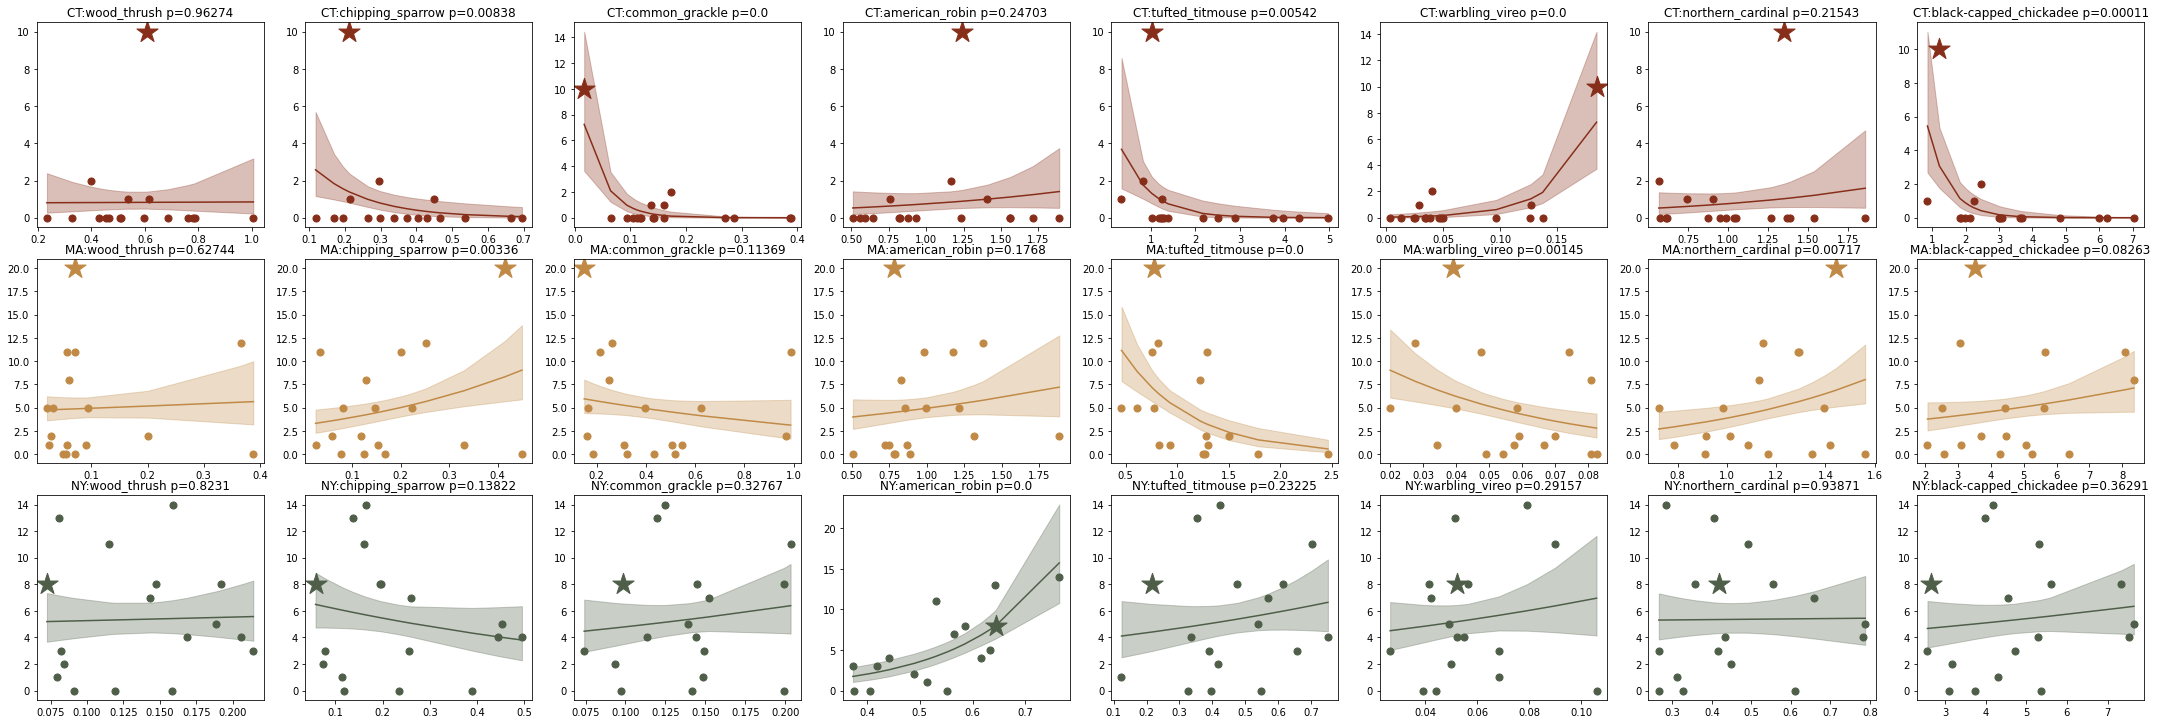

In [204]:
prop_case_high = make_figure("proportion", "cases", proportions, case_dict, high_birds, "proportion_cases_high.pdf")

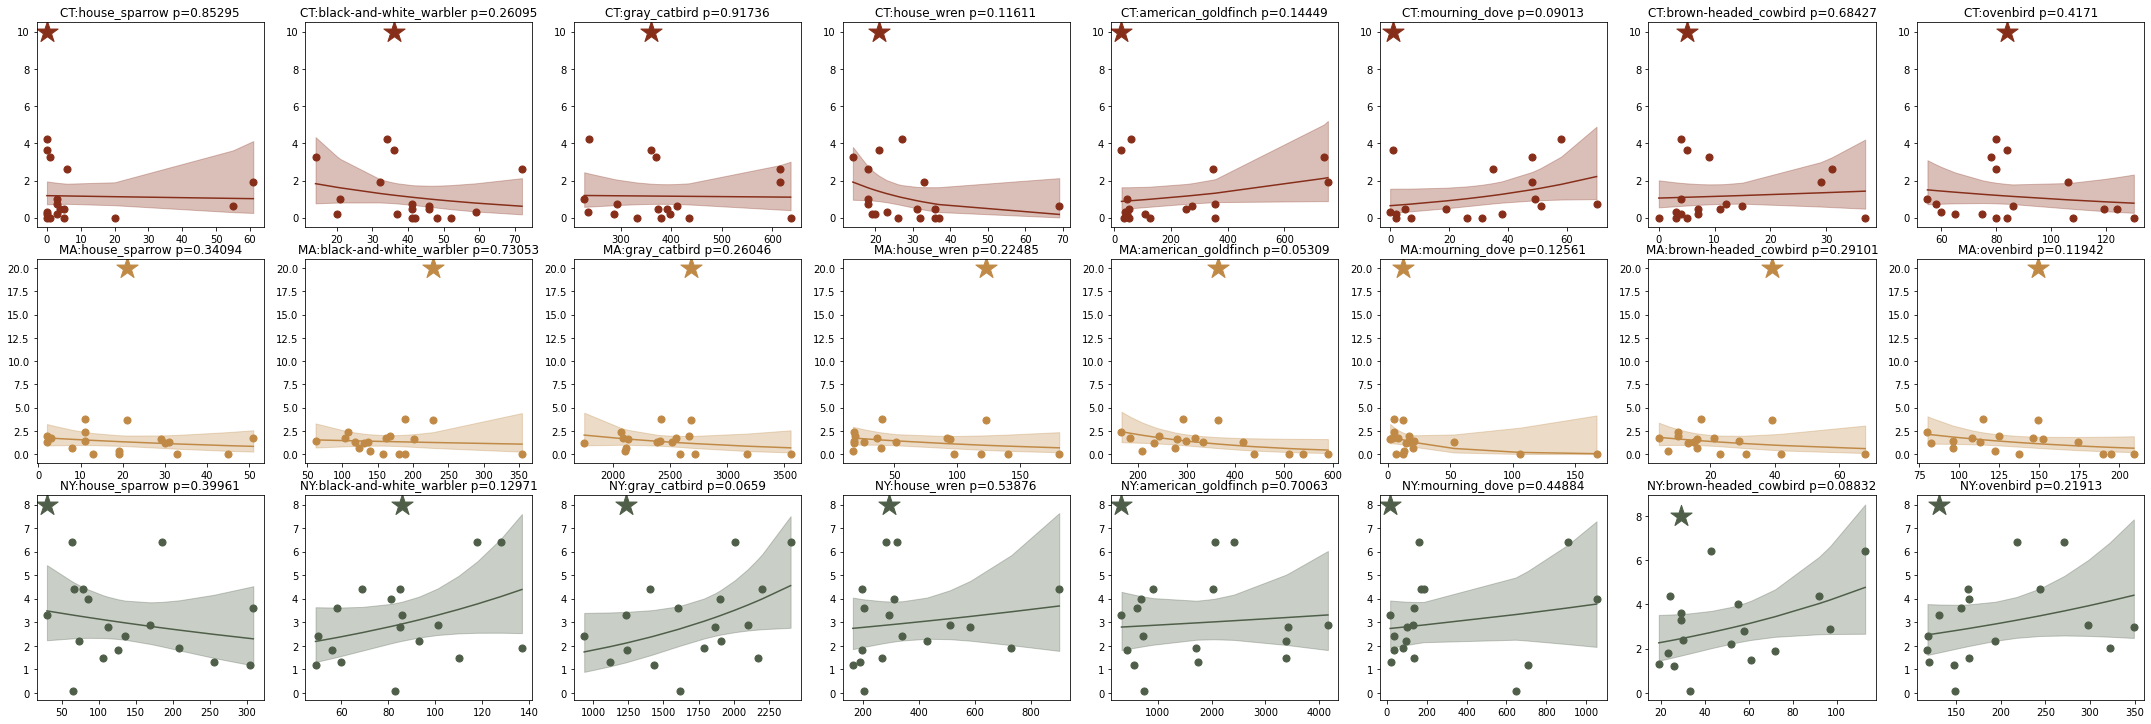

In [205]:
abun_ir_low = make_figure("abundance", "infection_rate", abundances, ir_dict, low_birds, "abundance_ir_low.pdf")

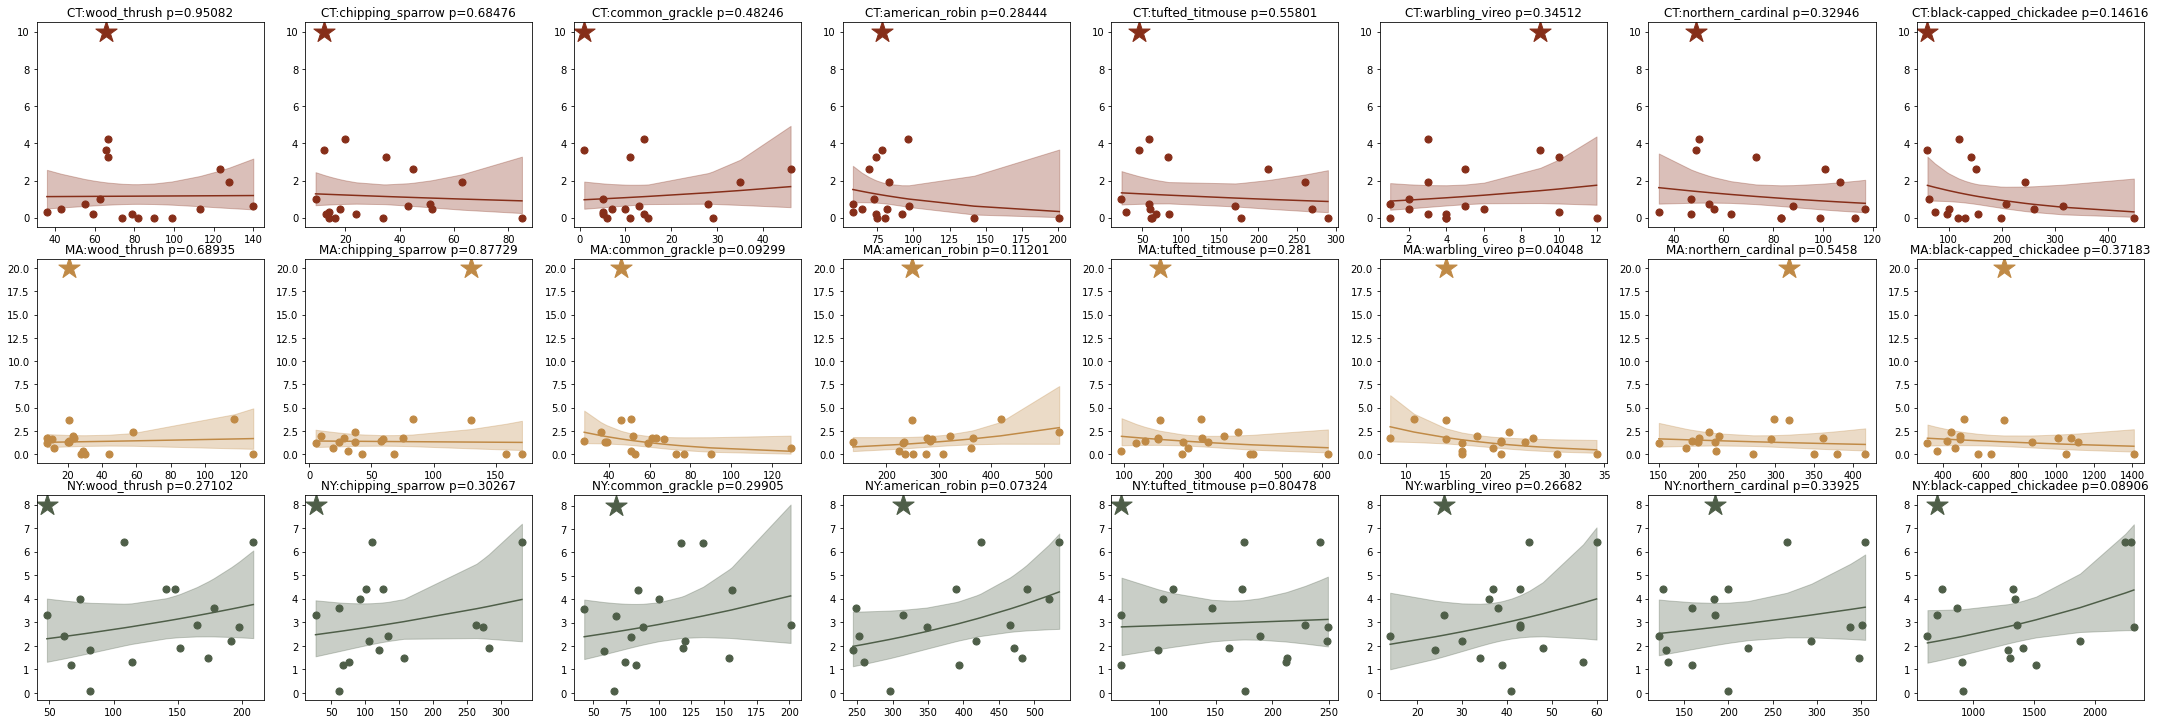

In [206]:
abun_ir_high = make_figure("abundance", "infection_rate", abundances, ir_dict, high_birds, "abundance_ir_high.pdf")

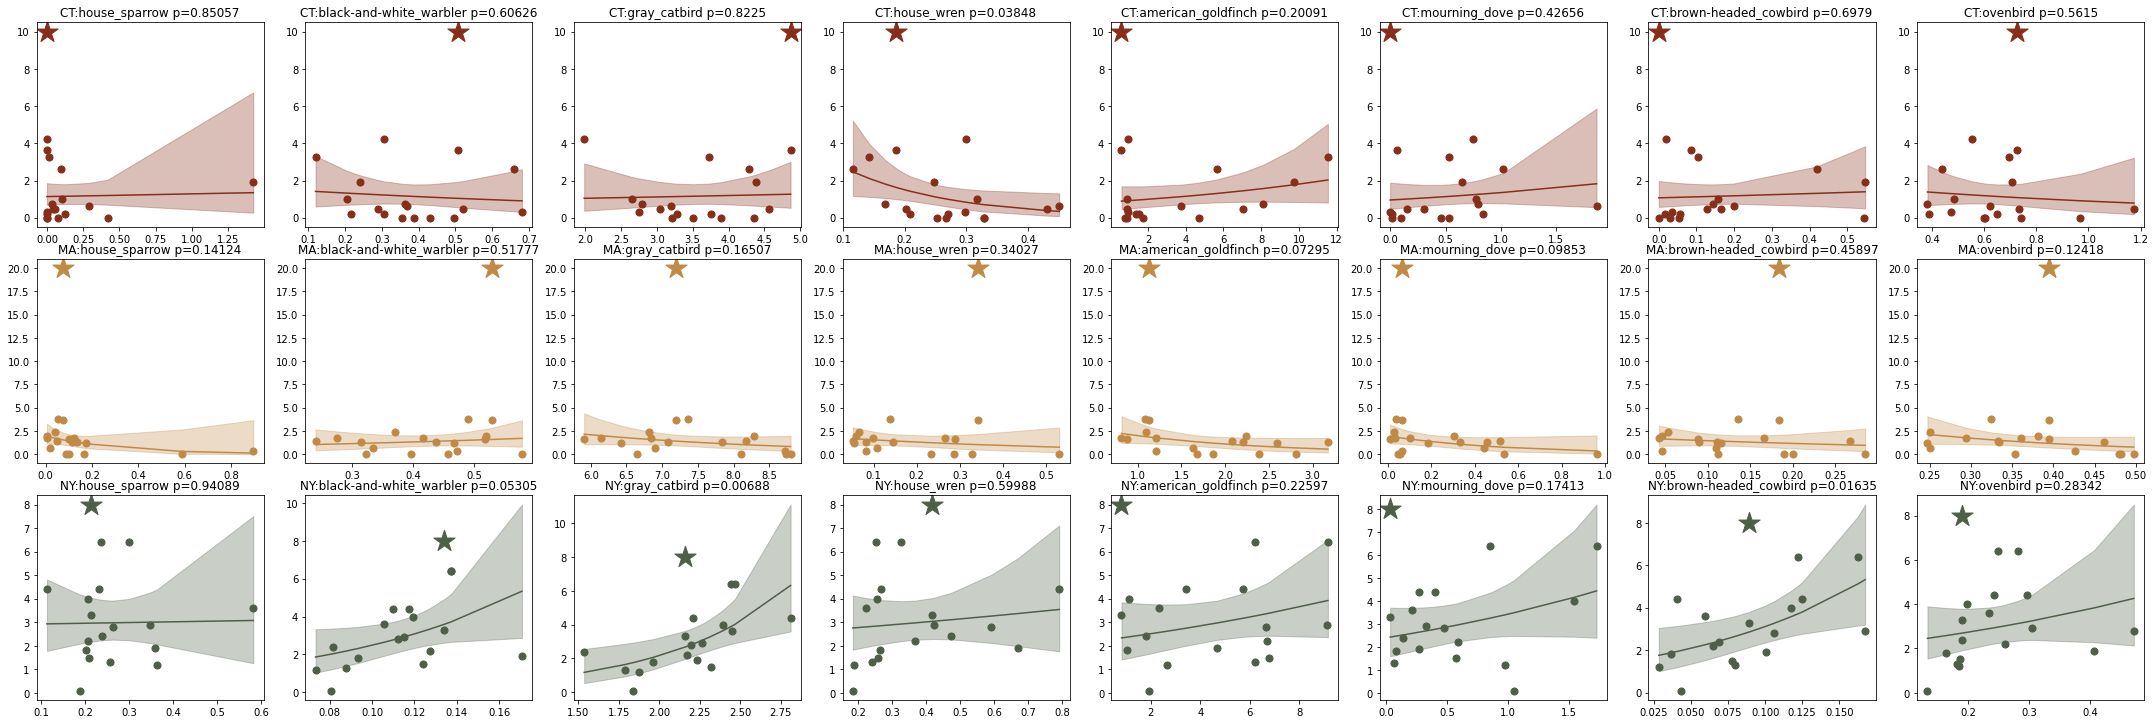

In [207]:
prop_ir_low = make_figure("proportion", "infection_rate", proportions, ir_dict, low_birds, "proportion_ir_low.pdf")

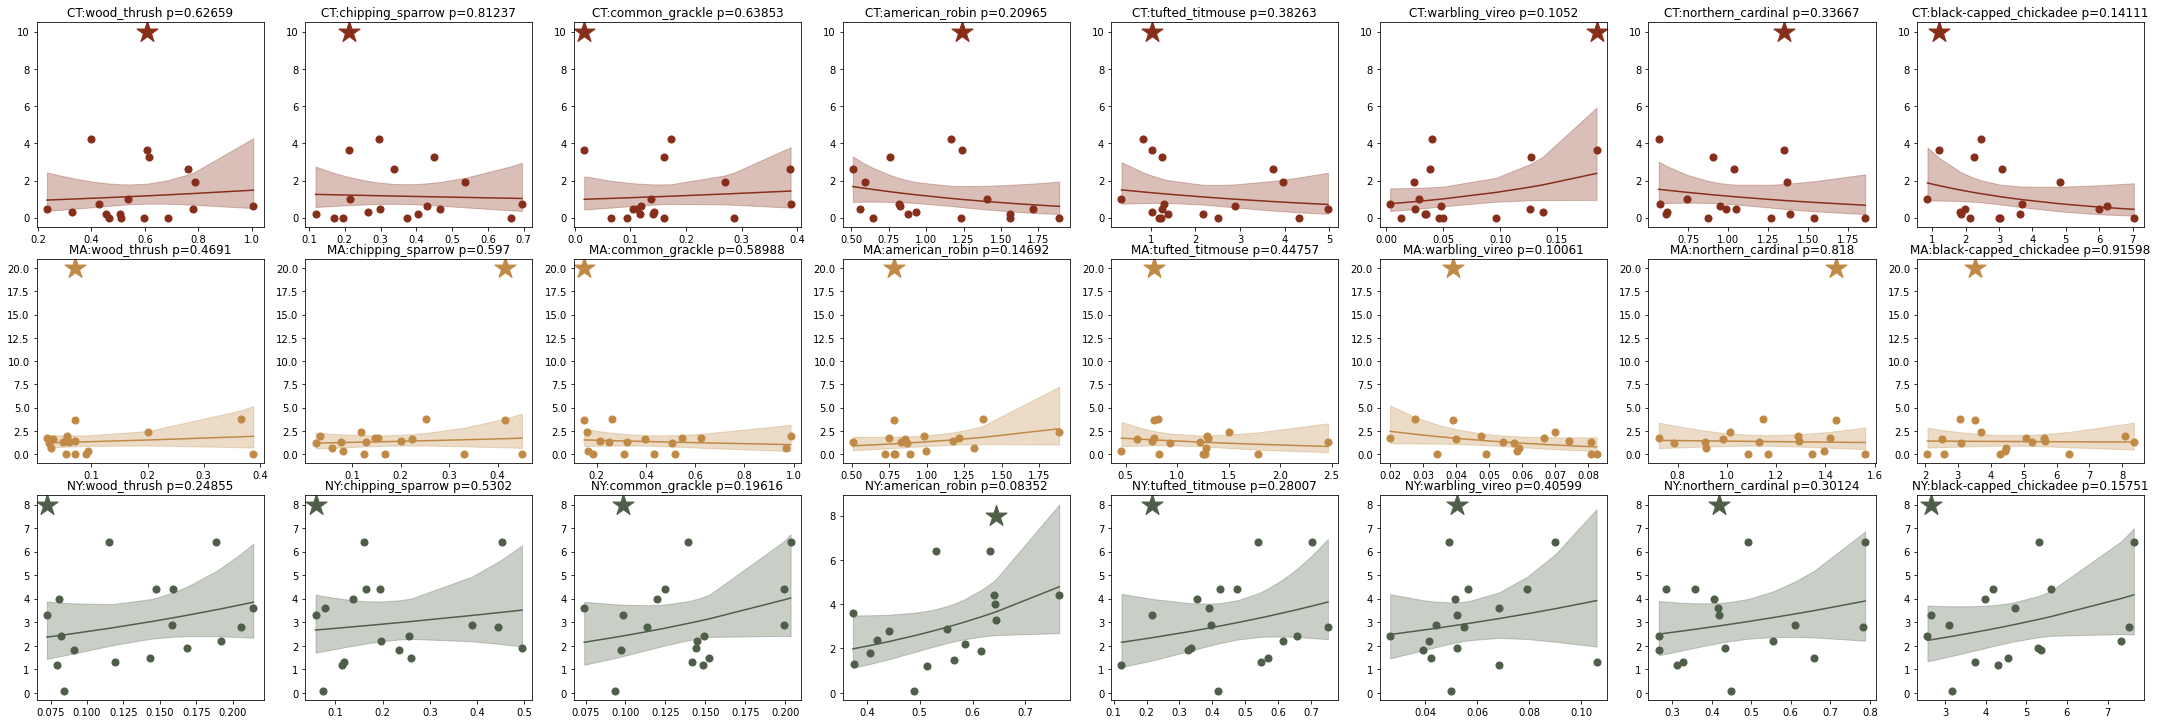

In [208]:
prop_ir_high = make_figure("proportion", "infection_rate", proportions, ir_dict, high_birds, "proportion_ir_high.pdf")

## heatmap

In [241]:
bird_results_list = [abun_case_high, abun_ir_high, prop_case_high, prop_ir_high] #all birds are in each list


In [287]:
def get_p_category(p_value):
    
    if p_value <= 0.01:
        category = 1
    elif p_value > 0.01 and p_value <= 0.05:
        category = 2
    elif p_value > 0.05 and p_value <= 0.1:
        category = 3
    else:
        category = 4

    return category

In [339]:
def make_heatmap(state):

    high_dict = defaultdict(list)
    low_dict = defaultdict(list)

    for bird, matrix in abun_case_high[state].items():
        if bird in high_birds:
            high_dict["bird"].append(f'{bird}_abundance')
            high_dict["response"].append("cases")
            high_dict["p-value"].append(matrix['p-value']["abundance"])
            high_dict["category"].append(get_p_category(matrix['p-value']["abundance"]))
        else:
            low_dict["bird"].append(f'{bird}_abundance')
            low_dict["response"].append("cases")
            low_dict["p-value"].append(matrix['p-value']["abundance"])
            low_dict["category"].append(get_p_category(matrix['p-value']["abundance"]))

    for bird, matrix in abun_ir_high[state].items():
        if bird in high_birds:
            high_dict["bird"].append(f'{bird}_abundance')
            high_dict["response"].append("infection_rate")
            high_dict["p-value"].append(matrix['p-value']["abundance"])
            high_dict["category"].append(get_p_category(matrix['p-value']["abundance"]))
        else:
            low_dict["bird"].append(f'{bird}_abundance')
            low_dict["response"].append("infection_rate")
            low_dict["p-value"].append(matrix['p-value']["abundance"])
            low_dict["category"].append(get_p_category(matrix['p-value']["abundance"]))
            

    for bird, matrix in prop_case_high[state].items():
        if bird in high_birds:
            high_dict["bird"].append(f'{bird}_prop')
            high_dict["response"].append("cases")
            high_dict["p-value"].append(matrix['p-value']["proportion"])
            high_dict["category"].append(get_p_category(matrix['p-value']["proportion"]))
        else:
            low_dict["bird"].append(f'{bird}_prop')
            low_dict["response"].append("cases")
            low_dict["p-value"].append(matrix['p-value']["proportion"])
            low_dict["category"].append(get_p_category(matrix['p-value']["proportion"]))

    for bird, matrix in prop_ir_high[state].items():
        if bird in high_birds:
            high_dict["bird"].append(f'{bird}_prop')
            high_dict["response"].append("infection_rate")
            high_dict["p-value"].append(matrix['p-value']["proportion"])
            high_dict["category"].append(get_p_category(matrix['p-value']["proportion"]))
        else:
            low_dict["bird"].append(f'{bird}_prop')
            low_dict["response"].append("infection_rate")
            low_dict["p-value"].append(matrix['p-value']["proportion"])
            low_dict["category"].append(get_p_category(matrix['p-value']["proportion"]))

    high_df = pd.DataFrame(high_dict)
    high_df = high_df.pivot("bird", "response", "p-value")
    
    low_df = pd.DataFrame(low_dict)
    low_df = low_df.pivot("bird", "response", "p-value")
    
    if state == "CT":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["#ED7C5D", "#6D2416"], N=4)
    elif state == "MA":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["#F9C995", "#896034"], N=4)
    elif state == "NY":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["#A9E0B1", "#4E5E48"], N=4)
    
    colors = []
    for i in range(4):
        colors.append(mpl.colors.rgb2hex(cmap(i)))
        
    fig, ax = plt.subplots(2,1, figsize=(10,20))
    fig.tight_layout()

    sns.heatmap(high_df, ax=ax[0], annot=True, cmap=colors, linewidths=2)
    sns.heatmap(low_df, ax=ax[1], annot=True, cmap=colors, linewidths=2)
    
#     plt.savefig(f"../../figures/supplementary/bird_fig/heatmap_{state}.pdf", bbox_inches="tight")

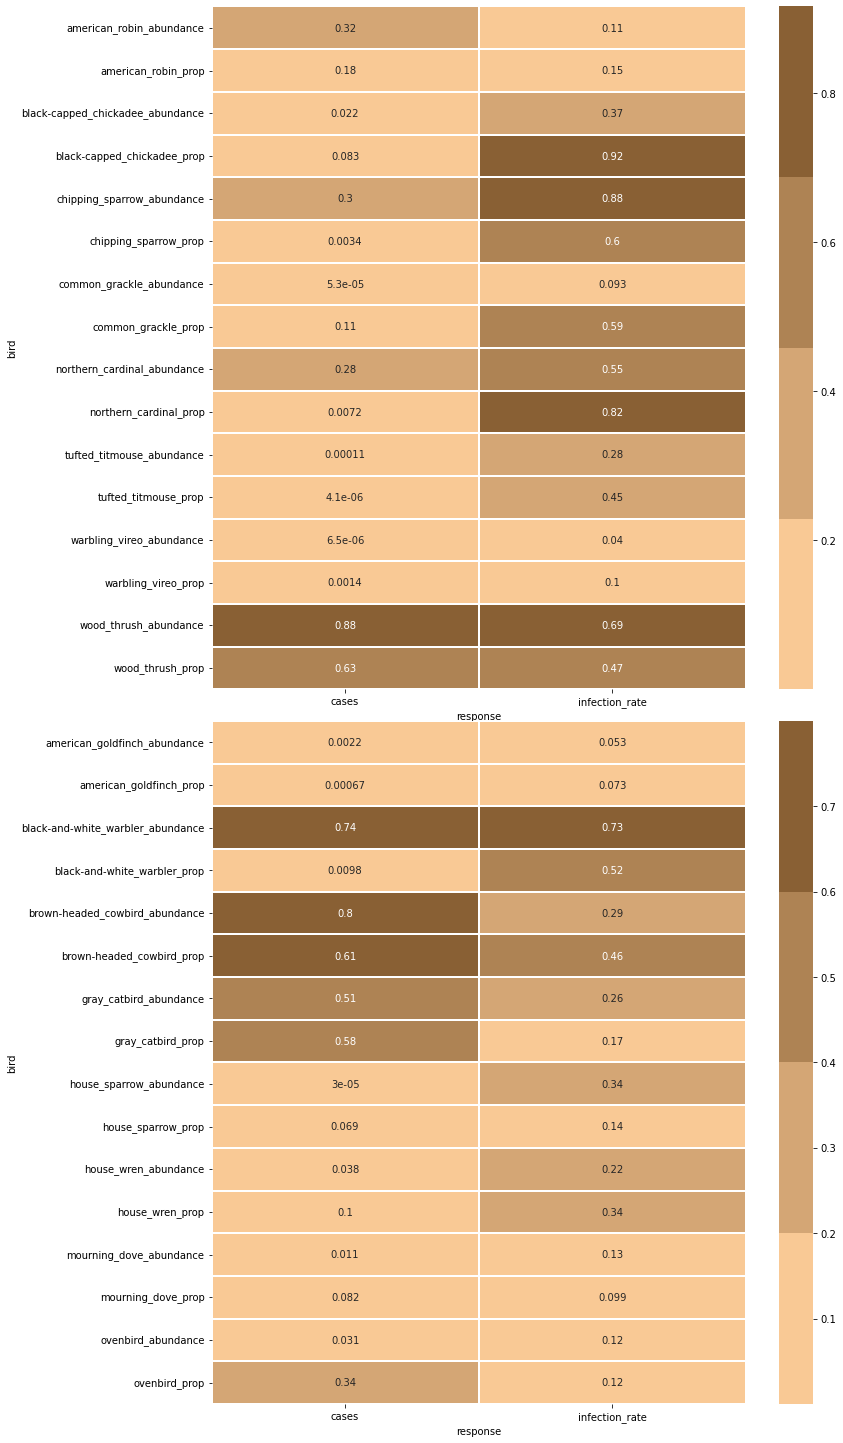

In [343]:
make_heatmap("MA")